# Data Challenge 8 — Introduction to Multiple Linear Regression (MLR)


**Format:** Instructor Guidance → You Do (Students) → We Share (Reflection)


**Goal:** Build an **MLR** model using **2–3 predictors** to predict one numeric target. Evaluate with a **train–test split** (MAE/RMSE), interpret **coefficients while holding others constant**, and compare against an **SLR baseline**.


> Dataset: **NYC Yellow Taxi — Dec 2023** (CSV). Keep code *simple*: light numeric coercion only for your chosen columns.

## Instructor Guidance

**Docs (quick links):**
- Train/Test Split — scikit‑learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- MAE / MSE / RMSE — scikit‑learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
- OLS (fit/predict/residuals) — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html
- OLS Results (`resid`, `fittedvalues`, `summary`) — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html
- Q–Q plot — SciPy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html


### Pseudocode Plan (for **MLR**)
1) **Load CSV** → preview columns/shape.
2) **Assign Y and Xs (2–3 predictors)** → pick numeric columns that matter; if needed, coerce **just** these to numeric and drop NAs.
3) **Add intercept** → `X = add_constant(X_matrix)`.
4) **Train–test split (80/20)** → `X_train, X_test, y_train, y_test = train_test_split(...)` (set `random_state`).
5) **Fit on TRAIN** → `model = OLS(y_train, X_train).fit()`.
6) **Predict on TEST** → `y_pred = model.predict(X_test)`.
7) **Evaluate on TEST** → compute **MAE** and **RMSE** using `y_test` & `y_pred`; speak in **units of Y**.
8) **Diagnostics on TRAIN** → use `model.resid` & `model.fittedvalues` for residuals vs fitted; Q–Q plot; check Durbin–Watson in `model.summary()`.
9) **Bias–variance read (optional)** → compare train vs test errors.
10) **Stakeholder one‑liner** → MAE/RMSE in units + brief reliability note. *(Optional)* Contrast with an **SLR baseline** using the strongest single predictor.

## You Do — Student Section
Work in pairs. Keep code simple and comment your choices.

### Step 0 — Setup & Imports

In [1]:
import pandas as pd, numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

### Step 1 — Load CSV & Preview
- Point to your **Dec 2023** taxi CSV.
- Print **shape** and **columns**.

**Hint: You may have to drop missing values and do a force coercion to make sure the variables stay numeric (other coding assignments may help)**

In [2]:
df = pd .read_csv('/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv')

/var/folders/v2/9k8drrwj5h39kpr935vvx6j80000gn/T/ipykernel_33664/1421944564.py:1: DtypeWarning: Columns (4,10,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd .read_csv('/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv')


In [3]:
df.shape

(3310907, 19)

In [4]:
df.keys()

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [5]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,12/01/2023 04:11:39 PM,12/01/2023 04:19:13 PM,2.0000,0.69,1.0000,N,141,140,1,7.9000,2.5000,0.5000,3.0000,0.0000,1.0000,17.4000,2.5000,0.0000
1,1,12/01/2023 04:11:39 PM,12/01/2023 04:20:41 PM,3.0000,1.1,1.0000,N,236,263,2,10.0000,5.0000,0.5000,0.0000,0.0000,1.0000,16.5000,2.5000,0.0000
2,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0000,1.57,1.0000,N,48,239,4,-10.7000,-2.5000,-0.5000,0.0000,0.0000,-1.0000,-17.2000,-2.5000,0.0000
3,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0000,1.57,1.0000,N,48,239,4,10.7000,2.5000,0.5000,0.0000,0.0000,1.0000,17.2000,2.5000,0.0000
4,1,12/01/2023 04:11:39 PM,12/01/2023 04:34:39 PM,2.0000,3,1.0000,N,164,211,1,21.9000,5.0000,0.5000,3.0000,0.0000,1.0000,31.4000,2.5000,0.0000


### Step 2 —  Pick Target **Y** and Predictors **Xs** (choose 2–3 numeric)

- **Avoid** using an X that directly defines Y (e.g., `total_amount` when Y = `fare_amount`).
- Coerce **only these columns** to numeric; drop NA rows.

In [6]:
# y being fare_amount and x being tolls_amount, tip_amount
# coerce errors to NaN and then drop those rows
df['fare_amount'] = pd.to_numeric(df['fare_amount'], errors='coerce')
df['tolls_amount'] = pd.to_numeric(df['tolls_amount'], errors='coerce')
df['tip_amount'] = pd.to_numeric(df['tip_amount'], errors='coerce')
df = df.dropna(subset=['fare_amount', 'tolls_amount', 'tip_amount']) 

In [7]:
# clean the data
df = df[(df['fare_amount'] > 0) & 
        (df['tolls_amount'] >= 0) & 
        (df['tip_amount'] >= 0)]


In [8]:
df[['fare_amount', 'tolls_amount', 'tip_amount']].describe()

,fare_amount,tolls_amount,tip_amount
count,"3,268,025.0000","3,268,025.0000","3,268,025.0000"
mean,20.1555,0.5872,3.5570
std,18.1667,2.2227,4.1220
min,0.0100,0.0000,0.0000
25%,9.3000,0.0000,0.6300
50%,14.2000,0.0000,2.8500
75%,23.3000,0.0000,4.5500
max,945.9000,161.3800,380.0000


<Axes: xlabel='tolls_amount', ylabel='fare_amount'>

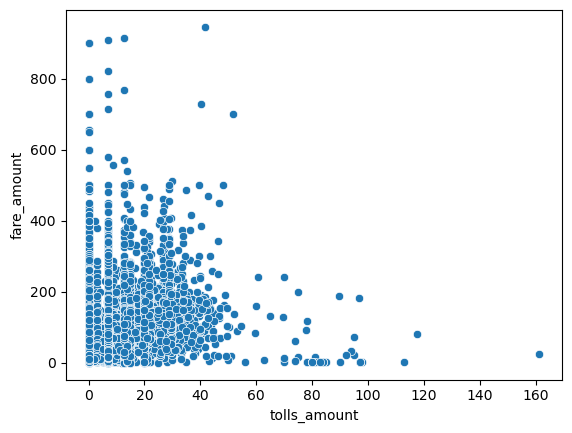

In [9]:
import seaborn as sns
sns.scatterplot(x='tolls_amount', y='fare_amount', data=df)

<Axes: xlabel='tip_amount', ylabel='fare_amount'>

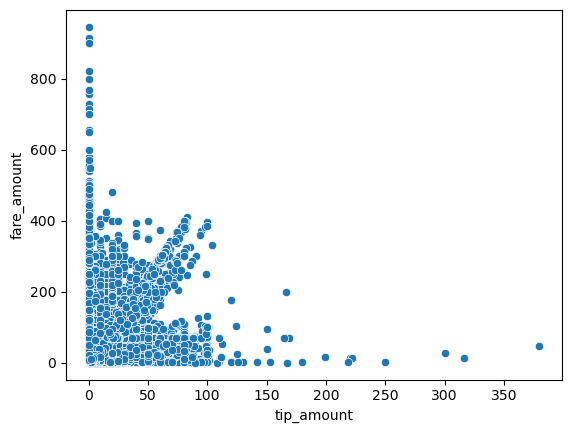

In [10]:
sns.scatterplot(x='tip_amount', y='fare_amount', data=df)

### Step 3 —  Design Matrix (add intercept) & Train–Test Split (80/20)

- Add intercept with `sm.add_constant`.
- Use a **random_state** for reproducibility.
- (Optional) Discuss when a **time‑aware** split is better.
    - A time aware split is bascially when you train your model on past data and test it on future data. It's best used when your dataset has trends over time, future data depends on past patterns such as web traffic, and weather. It is also used when you are modeling evolving behavior. On the other hand, a random split which is what we've been doing is good to use when your data is independent of time. 

In [11]:
# add intercept with sm.add_constant
X = df[['tolls_amount', 'tip_amount']]
X = sm.add_constant(X)
y = df['fare_amount']

### Step 4 — Fit MLR on TRAIN & Interpret Coefficients (holding others constant)

- Print the **coefficient table**.
- Write **one unit‑based sentence per coefficient** using “**holding others constant**.”
    - When no tolls or tips are applied, the base fare starts at around $12.25. Each additional $1 in tolls is associated with about a $3.69 increase in the total fare, while each additional $1 in tip adds about $1.61 to the fare, holding other factors constant. 

In [12]:
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                 1.568e+06
Date:                Mon, 03 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:22:39   Log-Likelihood:            -1.3014e+07
No. Observations:             3268025   AIC:                         2.603e+07
Df Residuals:                 3268022   BIC:                         2.603e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           12.2480      0.010   1283.578   

*Template (edit to your variables & units):*
- **β_intercept (const):** Baseline Y when all predictors are 0 (may be a math anchor).
    - The base fare starts at about $12.25 when there are no tolls or tips.
- **β_X1:** Holding other predictors constant, +1 unit in **X1** is associated with **+β_X1** units in **Y**.
    - Holding tips the same, for every extra $1 spent on tolls, the total fare goes up by about $3.69.
- **β_X2:** Holding other predictors constant, +1 unit in **X2** is associated with **+β_X2** units in **Y**.
    - Holding tolls the same, for every extra $1 in tip, the fare goes up by around $1.61.
- *(If 3rd predictor)* **β_X3:** …
- **Significance:** Note **p‑values** and **95% CIs** (from statsmodels summary) if relevant.
    - Both predictors are highly significant (p < 0.001), meaning tolls and tips both have a strong relationship with fare amount. The model’s estimates are stable and reliable

### Step 5 — Evaluate on **Unseen Test Data** (MAE/RMSE in units of Y)
Compute MAE and RMSE and write a one‑sentence **stakeholder** readout.
- On average, the model’s fare predictions are off by about $8, with most errors falling within roughly $13 of the actual fare. This suggests the model gives a decent estimate of fare prices based on tolls and tips, though there’s still room to improve accuracy.

In [13]:
y_pred = model.predict(X)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')  

MAE: 8.0195, RMSE: 12.9784


### Step 6 — (Optional) Compare to an SLR Baseline
- Fit **SLR** using your strongest single predictor (e.g., `trip_distance`).
- Compare **MAE/RMSE** to your **MLR**; explain why MLR helped (or didn’t).
    - The MLR model (using both tolls and tips) performed better than the SLR model that only used tips. Its MAE dropped from 9.12 to 8.02 and RMSE from 14.89 to 12.97, meaning the predictions became more precise overall. Adding tolls helped because it captured extra variation in fares that tips alone couldn’t explain. 

In [14]:
X_slr = sm.add_constant(df['tip_amount'])
y = df['fare_amount']

model_slr = sm.OLS(y, X_slr).fit()
y_pred_slr = model_slr.predict(X_slr)

mae_slr = mean_absolute_error(y, y_pred_slr)
rmse_slr = np.sqrt(mean_squared_error(y, y_pred_slr))
print(f'SLR MAE: {mae_slr:.4f}, RMSE: {rmse_slr:.4f}')  

SLR MAE: 9.1214, RMSE: 14.8854


### Step 7 — Quick Diagnostics (Train Residuals)
- **Residuals vs Fitted:** random cloud ≈ good; cones/funnels suggest non‑constant variance.
- **Q–Q plot:** points roughly along diagonal (normality for inference).
- **Durbin–Watson:** printed in `model.summary()` (~2 suggests independence).

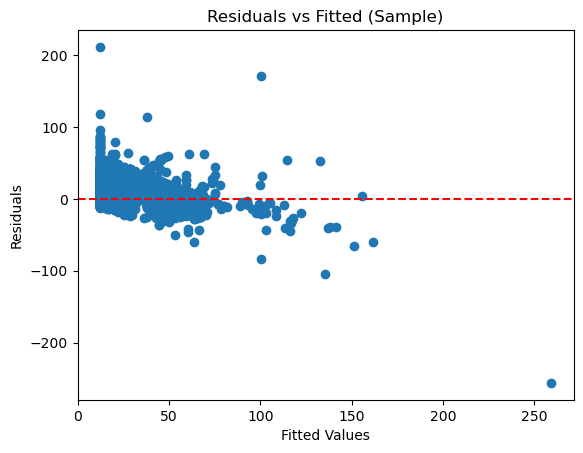

In [ ]:
# take a random sample of 10,000 rows because it wasn't printing before
sample = model.fittedvalues.sample(10000, random_state=1)
resid_sample = model.resid.loc[sample.index]

plt.scatter(sample, resid_sample)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted (Sample)')
plt.show()


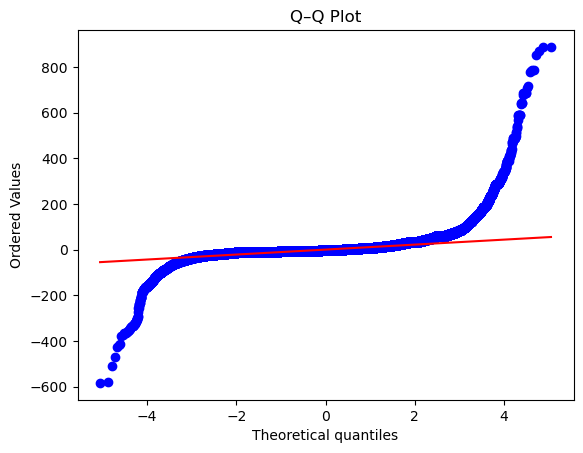

In [17]:
stats.probplot(model.resid, dist="norm", plot=plt)
plt.title("Q–Q Plot")
plt.show()

## We Share — Reflection & Wrap‑Up
Write **2 short paragraphs** and be specific:


1) **Which model would you trust today—MLR or SLR—and why?**
Use **test MAE/RMSE (units)**, coefficient interpretations (holding others constant), and any residual/correlation observations.
    -   I would trust the Multiple Linear Regression model more because it gave better results overall. The MLR had an MAE of about $8.02 and an RMSE of $12.97, while the SLR that only used tip amount had higher errors at $9.12 and $14.89. Adding toll amount made the predictions more accurate since it explained extra variation in fares that tips alone missed. Both predictors were statistically significant and had a positive relationship with fare amount. The residuals looked random and the Durbin-Watson value was close to 2, so the model seems reliable and well-fitted.


2) **What’s next to improve reliability?**
Options: add a more relevant predictor, use a **time‑aware split**, segment by ride type (airport vs. city), or prepare for **VIF/regularization** to handle collinearity.
    - To make the model stronger, I would try adding another relevant predictor like trip distance since distance directly affects fare. I would also check for multicollinearity using VIF to make sure the predictors are not too similar. Another improvement could be using a time-aware split, training on older rides and testing on newer ones, to see how well the model performs over time. These steps would help make the predictions more realistic and consistent.